# Social Representations and Boundaries of Humor: A focus on Gender roles

## The plan for this notebook

Here is a first tentative of a structure, ideas and methodology on how to analyse gender roles and representation in the New Yorker caption contest. Remember, the idea here is to start simple and then add complexity little by little.

0) Start with some basics plots and analysis:

    - When is the first mention of each gender ? 

    - How often men/women appear in the cartoon ? 

        a. To recognize if a man/woman is in the picture, the idea is to use the *image_descriptions* and *uncanny_image_descriptions* that are contained in the metadata. **For the cartoons after contest 763 we don't have this metadata**, this is a problem for later where I'll need to find a way to add a description to the images that don't have one. Or find an model that detect men/women in a cartoon.

        b. When this is done, I can do several plots. The first being a bar plot with just the distribution of gender over all the cartoons. Then I can plot the evolution of the gender distribution over time, to see if it is constant or not. 

        Maybe there is a need for normalisation somewhere to allow comparision ?

    - How often men/women are mentionned in the captions ?

        I think this is interesting to link this with part 0.a. Are men more mentionned when there is a man in the picture or not, same for women ? Are men mentionned in the caption even if there are no men in the picture, same for women ? Does the humor around one gender depends on referencing the other ? (Add a simple “co-occurrence” heatmap → e.g., men in image × women in caption, women in image × men in caption.)

        **Remark:** Since there are a lot of caption for each contest, to simplify this basic analysis, I'll look only in the top ten most voted captions.
        
        c. To do this, I can just find the mention of man/women in the captions. How ? For now, I haven't thought about it, I think we need a kind of list or something that can find word that are gender related maybe ?

        d. Same as 0.b, do some plots of the overall contest and then evolution over the years.

    - Gender-neutral cases: Track “no gender mention/no gender in image” as a category — this helps show if humor is becoming more or less gendered over time.

    - Timeline of first appearances: When did women start appearing more often? Is there a visible change after 2010 or so?


1) Dig in a little deeper: How are men vs women depicted.

    Do men and women come up in different contexts in the captions? One way to answer that question is to compare the words in sentences that discuss women with the words in sentences that discuss men.

    - Caption Analysis Word Clouds (Andras did that a bit already, try to reuse)
        Here the idea is to find gendered terms (e.g., “wife,” “husband,” “boss,” “nurse”) and their cooccurrences, to see if ... ?

    - Role Distribution Sankey Diagram: Flow from gender → depicted roles (domestic, professional, heroic, villainous). 

    - Do captions reinforce stereotypes and does the audience reward or punishes them ?

    **Suggestions from chat**: 

    - Build a small gendered lexicon manually first (e.g., “wife, husband, mom, dad, boss, nurse, secretary, CEO”). Then count frequencies of those words. Later, you could extend it using a prebuilt list (like LIWC or GenderedWords from textdescriptives).

    - Simple role classification: You don’t need machine learning yet — just group words into themes:

        1. Domestic (kitchen, home, dinner)

        2. Workplace (office, boss, meeting)

        3. Heroic/Action (police, firefighter, soldier)

    Then make a Sankey plot linking gender → role.

    - Caption polarity:

    Use sentiment analysis (e.g., TextBlob or VADER) to see if captions mentioning men vs women differ in sentiment. This is very simple to compute and could hint at bias (“are jokes about men more negative?”).

    - Audience response: If you have access to which captions won or were finalists, compare the proportion of gender-related captions among winners vs non-winners. This ties into the “does the audience reward stereotypes?” question.

2) Coming soon...

📊 Step 2 — Expanding later

Keep your “coming soon” section! Some easy next steps later could be:

Word embeddings to see what words cluster around “man” vs “woman.”

Topic modeling filtered by gender mentions.

Temporal word shift (how associations change over years).

## Initialisation of the absolute Github repository path

In [2]:
from pathlib import Path
import sys

root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)

Root folder at:  d:\GitHub\ada-2025-project-adacore42


## Imports

In [103]:
# utils
# from src.utils.general_utils import *

# paths
# from src.utils.paths import *

# working librairies
import os
import pickle
import csv

# basics
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go

# text processing libraries
import re
import glob
import nltk
from string import punctuation

## Loading of the preprocessed data pickle files

Use this when the data is stored in the right place.

In [7]:
# stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH

# # Chargement du fichier pickle
# with open(stored_dataprep_pkl_path, "rb") as f:
#     data = pickle.load(f)

# # Extraction des objets stockés dans le pickle

# # dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
# dataA = data['dataA']
# # dataC est un DataFrame de métadonnées de tous les cartoon contests.
# dataC = data['dataC']
# dataA_startID = data['dataA_startID']
# dataA_endID = data['dataA_endID']
# dataC_lastGoodID = data['dataC_lastGoodID']


Loading the data from Andras.

In [28]:
stored_dataprep_pkl_path = r'D:\EPFL\MA3\Applied Data Analysis\Project\cleaned_data_prepared 1.pkl'

with open(stored_dataprep_pkl_path, 'rb') as f:
    data = pickle.load(f)

In [29]:
# Extract the objects in the pickle

# dataA est une liste de DataFrames pandas (ou un objet similaire, comme un dictionnaire de DataFrames). Chaque élément de la liste contient un DataFrame avec 7 colonnes et un nombre variable de lignes.
dataA = data['dataA']
# dataC est un DataFrame de métadonnées de tous les cartoon contests.
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']

In [30]:
dataA[42].head()

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,cleaned_caption
rank,,,,,,,,
0,You were with Ringling Brothers? I was with Le...,1.982092,0.010177,6645,2347,2070,2228,ringing brother german brother
1,"Well, it suits you better than the president c...",1.931655,0.039002,556,255,84,217,well suit better president costume
2,"Sure, it's all fun and games. Until one of you...",1.916803,0.014894,3053,1171,965,917,sure fun game one get elected
3,"Hey, all I know is that they left in a very sm...",1.908179,0.017256,1993,691,794,508,hey know left small car
4,"Would you like that straight up, on the rocks,...",1.905750,0.014900,2939,1110,996,833,would like straight rock sprayed directly face


In [31]:
dataA[42].caption[1]

'Well, it suits you better than the president costume.'

In [32]:
dataC.head()

,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,date,cleaned_image_locations,cleaned_questions,cleaned_image_uncanny_descriptions,cleaned_image_descriptions
0,3905.0,41185.0,[the street],[A man is relaxing on a city street. Others ar...,[A man is just laying in the middle of the sid...,[https://en.wikipedia.org/wiki/Bystander_effec...,[Why is he laying there?],NaT,street,laying,man laying middle sidewalk,man relaxing city street others going business...
1,3325.0,28205.0,"[the front hard, a residential walkway]",[A man in a winter coat and cap is looking at ...,[It's unusual to see someone holding a snow sh...,"[https://en.wikipedia.org/wiki/Snowball_fight,...",[Is the man overly small or the shovel overly ...,NaT,front hard residential halfway,man overlay small shovel overlay big boy huge ...,unusual see someone holding snow shovel way ma...,man winter coat cap looking small bearded man ...
2,4399.0,21574.0,"[yoga place, a yoga studio]",[A man and woman are standing facing one anoth...,[Nothing is really out of place in this image....,"[https://en.wikipedia.org/wiki/Rug, https://en...","[Why is the man carrying a huge rug?, Why is t...",2016-03-21,place studio,man carrying huge rug man trying use living ro...,nothing really place image man huge rug big st...,man woman standing facing one another mirror i...
3,4141.0,16894.0,"[a workplace, an elevator]",[Three business men are walking down a hall. T...,[A suit case is usually carried by one person ...,[https://en.wikipedia.org/wiki/Worker_cooperat...,[Why is the briefcase big enough for three peo...,2016-03-27,workplace elevator,briefcase big enough three people carrying car...,suit case usually carried one person three sup...,three business men walking hall carrying brief...
4,3951.0,95790.0,[plains],[Some cowboys are riding through the desert. T...,[There are rocking horses in place of real hor...,"[https://en.wikipedia.org/wiki/Rocking_horse, ...",[Why is this chase taking place?],2016-04-03,plain,chase taking place,rocking horse place real horse,cowboy riding desert rocking horse


In [33]:
dataC.shape

(384, 12)

In [34]:
# find the where the NaN's are in the metadata
NaN_in_rows = dataC[dataC['image_descriptions'].isna()].index
no_NaN = dataC[dataC['image_descriptions'].notna()].index
print(NaN_in_rows)

# There are some NaN's in the metadata before index 251 !!!

# Let's remove them
dataC.dropna(subset=['image_descriptions'], inplace=True)

Index([ 16,  52,  76,  85,  93, 103, 132, 135, 144, 145,
       ...
       374, 375, 376, 377, 378, 379, 380, 381, 382, 383],
      dtype='int64', length=144)


In [36]:
print(no_NaN[14:20])

Index([14, 15, 17, 18, 19, 20], dtype='int64')


In [37]:
NaN_in_rows = dataC[dataC['image_descriptions'].isna()].index
print(NaN_in_rows)

dataC.shape

Index([], dtype='int64')


(240, 12)

We don't have NaN's in the image descriptions anymore that's good. Now, we need to be careful in our analysis of the captions not to look at the .csv coresponding to the rows we dropped. I'll use the list "NaN_in_rows" to only select the proper .csv

## Functions

Here is all the functions used in this notebook. This will be updated with the functions I know work and are useful so that I can easily put them in a .py later.

In [38]:
# Functions used in part 0

# function to detect if there is a mention of gender
def detect_gender(text):

    # gendered word lists
    # male_terms = ["man", "men", "guy", "boy", "husband", "dad", "father", "him", "he", "his"]
    # female_terms = ["woman", "women", "girl", "wife", "mom", "mother", "her", "she", "hers"]

    #Two lists  of words that are used when a man or woman is present, based on Danielle Sucher's https://github.com/DanielleSucher/Jailbreak-the-Patriarchy
    male_terms=['guy','spokesman','chairman',"men's",'men','him',"he's",'his','boy','boyfriend','boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers','fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom','he','himself','husband','husbands','king','male','man','mr','nephew','nephews','priest','prince','son','sons','uncle','uncles','waiter','widower','widowers']
    female_terms=['heroine','spokeswoman','chairwoman',"women's",'actress','women',"she's",'her','aunt','aunts','bride','daughter','daughters','female','fiancee','girl','girlfriend','girlfriends','girls','goddess','granddaughter','grandma','grandmother','herself','ladies','lady','lady','mom','moms','mother','mothers','mrs','ms','niece','nieces','priestess','princess','queens','she','sister','sisters','waitress','widow','widows','wife','wives','woman']
    
    #text = text.lower() # <- the text is already cleaned, don't need that
    male = any(re.search(rf"\b{word}\b", text) for word in male_terms)
    female = any(re.search(rf"\b{word}\b", text) for word in female_terms)
    if male and female:
        return "both"
    elif male:
        return "male"
    elif female:
        return "female"
    else:
        return "neutral"
    
# Functions used in part 1

def gender_the_sentence(sentence_words, male_words, female_words):

    """Takes a sentenece list and returns the gender of the person being talked about, 
    if any, based on the number of words a sentence has in common with either the male 
    or female word lists."""

    mw_length=len(male_words.intersection(sentence_words))
    fw_length=len(female_words.intersection(sentence_words))

    if mw_length>0 and fw_length==0:
        gender='male'
    elif mw_length==0 and fw_length>0: 
        gender='female'
    elif mw_length>0 and fw_length>0: 
        gender='both'
    else:
        gender='none'
    return gender


def is_it_proper(word, proper_nouns):
        
    """Function that identify proper nouns (noms propres). Since the caption
    is not a large text, this might not be robust, but let's see"""

    if word[0]==word[0].upper():
        case='upper'
    else:
        case='lower'
    
    word_lower=word.lower()
    try:
        proper_nouns[word_lower][case] = proper_nouns[word_lower].get(case,0)+1
    except:
        #This is triggered when the word hasn't been seen yet
        proper_nouns[word_lower]= {case:1}


def increment_gender(sentence_words,gender, sentence_counter, word_counter, word_freq):

    """Keeps track of each of the words in each sentence with a couple of counters
    This function doesn't return anything but it does increment 
    the word_freq, word_counter, and sentence_counter dictionaries."""

    sentence_counter[gender]+=1
    word_counter[gender]+=len(sentence_words)
    for word in sentence_words:
        word_freq[gender][word]=word_freq[gender].get(word,0)+1


## 0. Basic plots and analysis

First I need a systematic way to detect gender mention in a sentence. 

### Basic approach

Let's start with simple keyword matching to have a first grasp of what's happening. I defined two simple lists with basic gendered word and then created a function that detects if one of the word is used in a sentence. 

- For the images, I'll use the cleaned image descriptions
- For the captions, I'll use the top 10 cleaned captions

In [40]:
# Let's look at the images

# !! Since we don't have the metadata after contest 763, I need to do some slicing
# last_idx = 251
# dataC0 = dataC[dataC.index <= last_idx].copy(deep=True)

dataC0 = dataC.copy(deep = True)

# put it in lower case
dataC0["image_descriptions"] = dataC0["image_descriptions"].apply(
    lambda x: [s.lower() for s in x] if isinstance(x, list) else str(x).lower()
)

# remove the []
dataC0["image_descriptions"] = dataC0["image_descriptions"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

dataC0['gender_mention'] = dataC0['image_descriptions'].apply(detect_gender)

print(dataC0.shape)

# check
dataC0.tail()

(240, 13)


,num_captions,num_votes,image_locations,image_descriptions,image_uncanny_descriptions,entities,questions,date,cleaned_image_locations,cleaned_questions,cleaned_image_uncanny_descriptions,cleaned_image_descriptions,gender_mention
247,9411.0,779033.0,"[the ocean, the sea]",two fish are in the ocean and they seem to be ...,[One of the fish that is mounted on the wall l...,[https://en.wikipedia.org/wiki/Big_Mouth_Billy...,[How is the mounted fish still alive and able ...,2021-06-28,ocean sea,mounted fish still alive able swim fish alive ...,one fish mounted wall like trophy still alive ...,two fish ocean seem discussion one fish normal...,neutral
248,7393.0,807956.0,[a restaurant],two identical waiters approach a couple sittin...,[A waiter is carrying a garbage can to a table...,"[https://en.wikipedia.org/wiki/Waiting_staff, ...",[Why is the waiter bringing the couple garbage...,2021-07-05,restaurant,waiter bringing couple garage waiter bringing ...,waiter carrying garage table restaurant water ...,two identical water approach couple sitting on...,male
249,10712.0,926127.0,[a field],death is giving some food to a man. he is sayi...,[Death doesn't usually give things to people.],[https://en.wikipedia.org/wiki/Death_(personif...,[Are they neighbors?],2021-07-19,field,neighbor,death usually give thing people,death giving food man saying something woman side,both
250,7076.0,901611.0,"[experimental facility, hamster cage]",a mouse is conducting a hamster wheel experime...,[The rat is holding a clipboard and standing u...,"[https://en.wikipedia.org/wiki/Mouse, https://...","[Why is the mouse conducting the experiment?, ...",2021-07-26,experimental facility master cage,mouse conducting experiment saying turtle turt...,rat holding cupboard standing upright mouse co...,mouse conducting master wheel experiment mouse...,neutral
251,9007.0,889556.0,"[a gas station, gas station]",there is a huge hot dog mobile outside a build...,"[A hot dog car is outside, which is weird., Th...","[https://en.wikipedia.org/wiki/Customer, https...","[Why is the hot dog car colored in?, Why is th...",2021-08-02,gas station gas station,hot dog car colored huge hot dog mobile employ...,hot dog car outside weird vehicle station unus...,huge hot dog mobile outside building man talki...,both


In [41]:
# Let's look at the top ten captions
dataTop10 = []

count = []

# !! Since we don't have the metadata for some contest we need to use specfic .csv


for idx in no_NaN:

    contest = dataA[idx]

    # Keep only the top 10
    df_top10 = contest[contest.index < 10].copy(deep = True)

    # put it in lower case
    df_top10["caption"] = df_top10["caption"].apply(
        lambda x: [s.lower() for s in x] if isinstance(x, list) else str(x).lower()
    )

    # for each of them apply the function to detect gender
    df_top10['gender_mention'] = df_top10['caption'].apply(detect_gender)

    dataTop10.append(df_top10)

    # Count mentions per contest
    gender_counts = (
        df_top10["gender_mention"]
        .value_counts()
        #.unstack(fill_value=0)
        .reset_index()
    )

    count.append(gender_counts)

#dataTop10[0]

In [42]:
# check the number of contests

len(dataTop10)

240

In [43]:
# what if we look at the top 3 captions

# Let's look at the top ten captions
dataTop3 = []

count3 = []

# !! Since we don't have the metadata after contest 763 we don't need to do this for all of our data

for idx in no_NaN:

    contest = dataA[idx]

    # Keep only the top 3
    df_top3 = contest[contest.index < 3].copy(deep = True)

    # put it in lower case
    df_top3["caption"] = df_top3["caption"].apply(
        lambda x: [s.lower() for s in x] if isinstance(x, list) else str(x).lower()
    )

    # for each of them apply the function to detect gender
    df_top3['gender_mention'] = df_top3['caption'].apply(detect_gender)

    dataTop3.append(df_top3)

    # Count mentions per contest
    gender_counts = (
        df_top3["gender_mention"]
        .value_counts()
        #.unstack(fill_value=0)
        .reset_index()
    )

    count3.append(gender_counts)

dataTop3[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,cleaned_caption,gender_mention
rank,,,,,,,,,
0,i'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,congressmenobstruction job,neutral
1,"i'm what they mean when they say, 'the middle ...",1.842105,0.191381,19,8,6,5,mean say middle class getting stepped,neutral
2,does this suit make me look flat?,1.711111,0.112915,45,21,16,8,suit make look flat,neutral


In [44]:
#dataC0.head()

# the function seems to be working with those basic word, sometimes there are captions that contains gendered word that we of course miss
# but it's a good start.

Now that I have this, I can do some plots.

### How often men/women appear in a cartoon ?

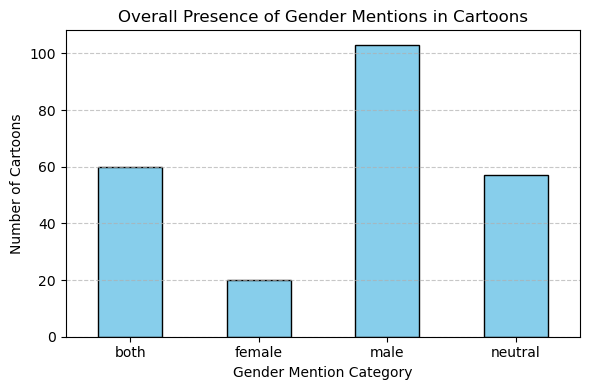

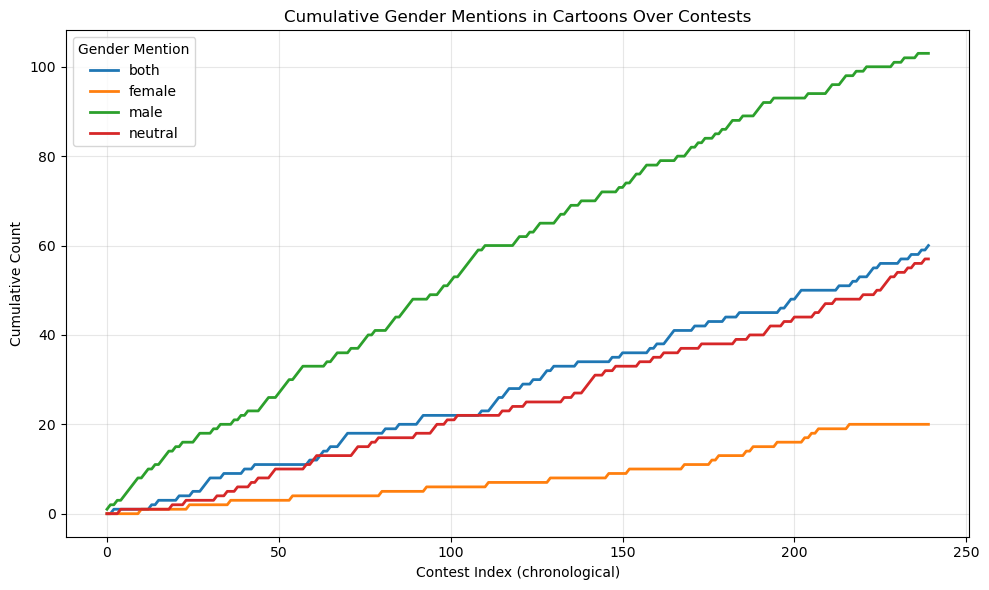

In [45]:
# How often men/women appear in a cartoon ?

# Overall distribution of gender over all the cartoons.
gender_image = dataC0['gender_mention']

# Count frequency
gender_counts = gender_image.value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Presence of Gender Mentions in Cartoons")
plt.xlabel("Gender Mention Category")
plt.ylabel("Number of Cartoons")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Evolution over time
df = pd.DataFrame({"contest_index": range(0, len(dataC0)),
                   "gender_mention": dataC0['gender_mention']})

# Count mentions per contest (here each row = one contest)
counts = pd.get_dummies(df["gender_mention"]).cumsum()

# Compute cumulative counts
cumulative = counts.cumsum()

# Plot cumulative counts
plt.figure(figsize=(10, 6))
for col in counts.columns:
    plt.plot(df["contest_index"], counts[col], label=col, linewidth=2)

plt.title("Cumulative Gender Mentions in Cartoons Over Contests")
plt.xlabel("Contest Index (chronological)")
plt.ylabel("Cumulative Count")
plt.legend(title="Gender Mention")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### How often men/women appear in the top 10 captions ?

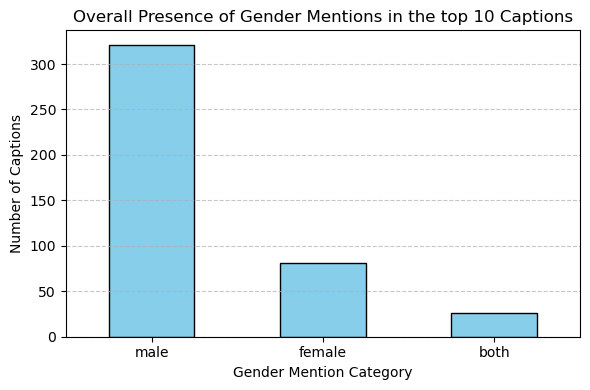

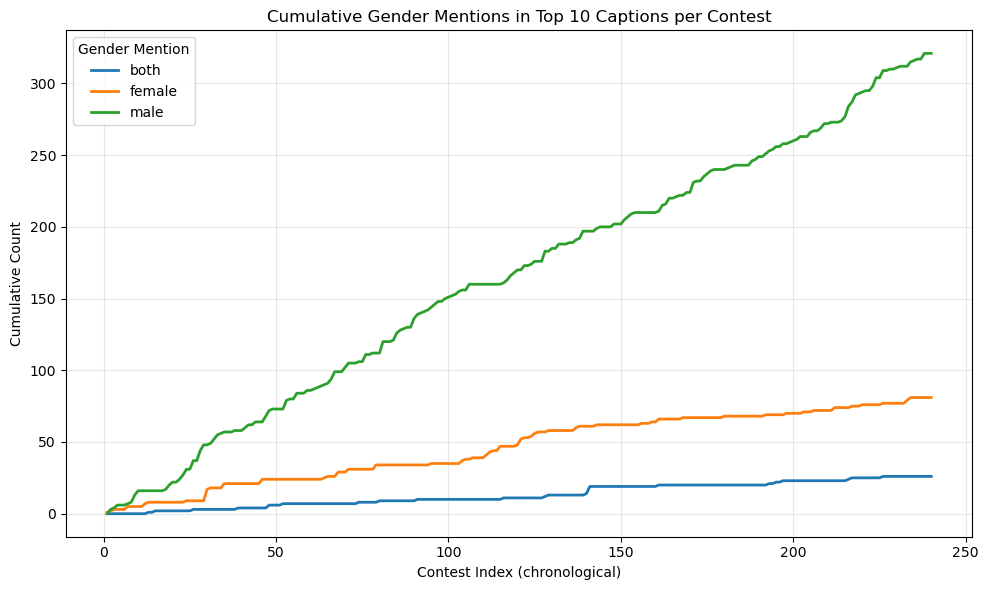

In [46]:
# How often men/women are mentionned in captions
# Overall distribution of gender over all the top 10 captions.

# Combine all contests
combined = []
for i, df in enumerate(count):
    temp = df.copy()
    temp["contest_index"] = i + 1  # add contest number
    combined.append(temp)

all_count = pd.concat(combined, ignore_index=True)
pivoted = (
    all_count.pivot(index="contest_index", columns="gender_mention", values="count")
    .fillna(0)
    .sort_index()
)

overall_counts = (
    all_count.groupby("gender_mention")["count"]
    .sum()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(6, 4))
overall_counts[["male", "female", "both"]].plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Presence of Gender Mentions in the top 10 Captions")
plt.xlabel("Gender Mention Category")
plt.ylabel("Number of Captions")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Evolution over time
cumulative = pivoted.cumsum()

plt.figure(figsize=(10, 6))
# removed the neutral, because it has a really a high cumulative value.
for col in cumulative.columns[:-1]:
    plt.plot(cumulative.index, cumulative[col], label=col, linewidth=2)

plt.title("Cumulative Gender Mentions in Top 10 Captions per Contest")
plt.xlabel("Contest Index (chronological)")
plt.ylabel("Cumulative Count")
plt.legend(title="Gender Mention")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



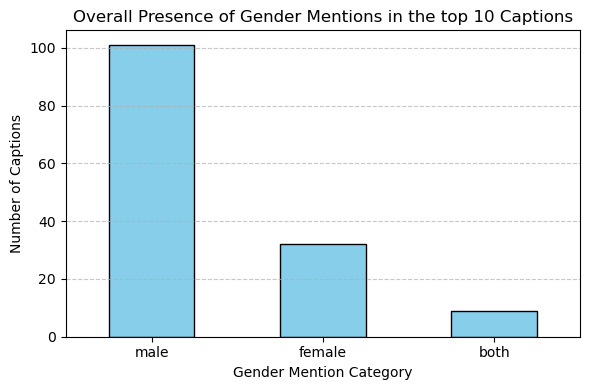

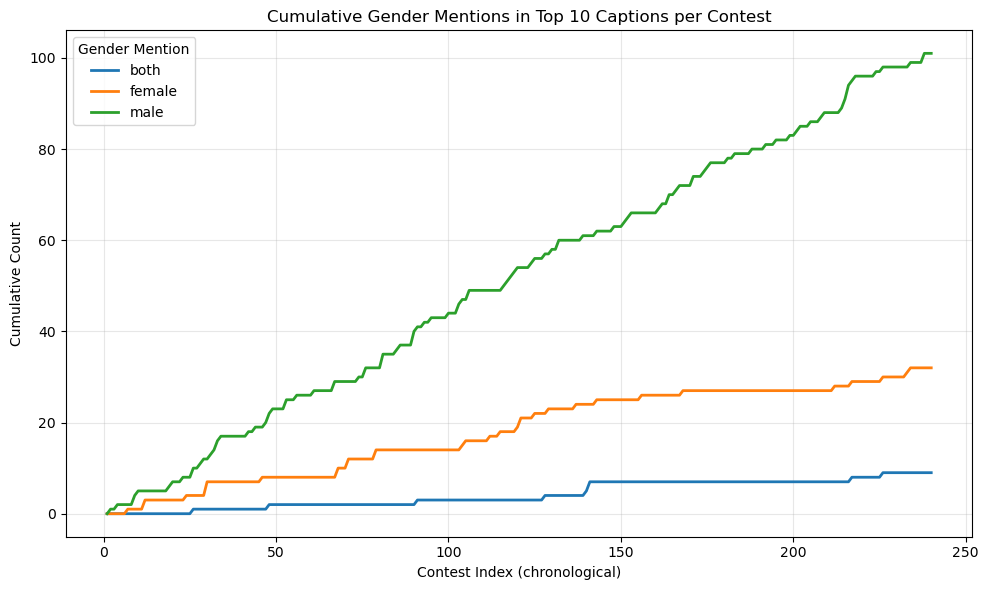

In [47]:
# How often men/women are mentionned in captions
# Overall distribution of gender over all the top 3 captions.

# Combine all contests
combined = []
for i, df in enumerate(count3):
    temp = df.copy()
    temp["contest_index"] = i + 1  # add contest number
    combined.append(temp)

all_count = pd.concat(combined, ignore_index=True)
pivoted = (
    all_count.pivot(index="contest_index", columns="gender_mention", values="count")
    .fillna(0)
    .sort_index()
)

overall_counts = (
    all_count.groupby("gender_mention")["count"]
    .sum()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(6, 4))
overall_counts[["male", "female", "both"]].plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Overall Presence of Gender Mentions in the top 10 Captions")
plt.xlabel("Gender Mention Category")
plt.ylabel("Number of Captions")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Evolution over time
cumulative = pivoted.cumsum()

plt.figure(figsize=(10, 6))
# removed the neutral, because it has a really a high cumulative value.
for col in cumulative.columns[:-1]:
    plt.plot(cumulative.index, cumulative[col], label=col, linewidth=2)

plt.title("Cumulative Gender Mentions in Top 10 Captions per Contest")
plt.xlabel("Contest Index (chronological)")
plt.ylabel("Cumulative Count")
plt.legend(title="Gender Mention")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### Heatmap

- Are men more mentionned when there is a man in the picture or not, same for women ? 
- Are men mentionned in the caption even if there are no men in the picture, same for women ? 
- Does the humor around one gender depends on referencing the other ? 

Let's look at cross-relationships between gender in the image and gender in the caption. Here we'll look at this relationship for the top voted caption.

In [48]:
list_top1_gender = []

for idx in no_NaN:

    contest = dataA[idx]

    # Keep only the top 1
    df_top1 = contest[contest.index == 1].copy(deep = True)

    # for each of them apply the function to detect gender
    list_top1_gender.append(df_top1['cleaned_caption'].apply(detect_gender).values[0])
    
df_gender = pd.DataFrame({"image_gender": dataC0['gender_mention'],"caption_gender": list_top1_gender})

# Cross-tabulation: counts of each combination
cross = pd.crosstab(df_gender["image_gender"], df_gender["caption_gender"])

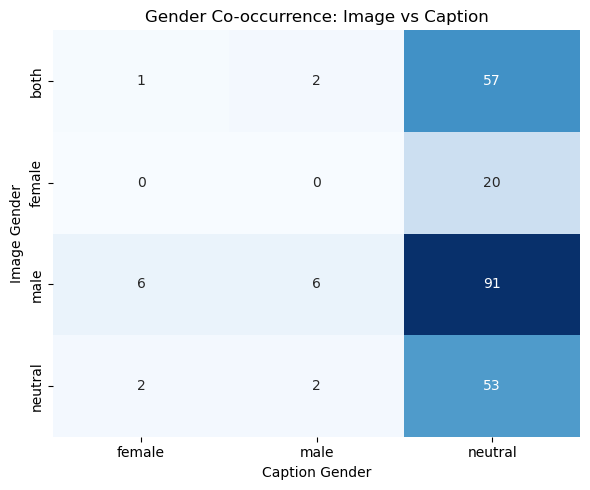

In [49]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cross,
    annot=True, fmt="d",
    cmap="Blues", cbar=False
)
plt.title("Gender Co-occurrence: Image vs Caption")
plt.xlabel("Caption Gender")
plt.ylabel("Image Gender")
plt.tight_layout()
plt.show()

### A different approach

Different approach

**Use this THANK YOU TO THIS GOAT**

https://nealcaren.github.io/text-as-data/html/times_gender.html

In [59]:
nltk.data.path

['C:\\Users\\Amélie/nltk_data',
 'd:\\Anaconda\\envs\\ada\\nltk_data',
 'd:\\Anaconda\\envs\\ada\\share\\nltk_data',
 'd:\\Anaconda\\envs\\ada\\lib\\nltk_data',
 'C:\\Users\\Amélie\\AppData\\Roaming\\nltk_data',
 'C:\\nltk_data',
 'D:\\nltk_data',
 'E:\\nltk_data',
 'D:\\EPFL\\MA3\\Applied Data Analysis\\nltk',
 'D:\\EPFL\\MA3\\Applied Data Analysis\\nltk']

In [58]:
# do only once !
nltk.download('punkt_tab', download_dir=r'D:\EPFL\MA3\Applied Data Analysis\nltk')
nltk.data.path.append(r'D:\EPFL\MA3\Applied Data Analysis\nltk')

[nltk_data] Downloading package punkt_tab to D:\EPFL\MA3\Applied Data
[nltk_data]     Analysis\nltk...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [60]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [65]:
# The same two lists  of words that are used when a man or woman is present, based on Danielle Sucher's https://github.com/DanielleSucher/Jailbreak-the-Patriarchy
male_terms=set(['guy','spokesman','chairman',"men's",'men','him',"he's",'his','boy','boyfriend','boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers','fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom','he','himself','husband','husbands','king','male','man','mr','nephew','nephews','priest','prince','son','sons','uncle','uncles','waiter','widower','widowers'])
female_terms=set(['heroine','spokeswoman','chairwoman',"women's",'actress','women',"she's",'her','aunt','aunts','bride','daughter','daughters','female','fiancee','girl','girlfriend','girlfriends','girls','goddess','granddaughter','grandma','grandmother','herself','ladies','lady','lady','mom','moms','mother','mothers','mrs','ms','niece','nieces','priestess','princess','queens','she','sister','sisters','waitress','widow','widows','wife','wives','woman'])

I set up the counters to store the various quantities of interest. These are the ones that modified in the increment_gender function. Some of the values probably don't need to be entered now, particularly for the word and sentence counters, but starting with zeroes helps remind me what they are for.

In [ ]:
sexes=['male','female','none','both']

# count of the number of sentences in the text
sentence_counter={sex:0 for sex in sexes}

# counter of words that relate to the genders
word_counter={sex:0 for sex in sexes}

# frequency that a word is associated with one gender
word_freq={sex:{} for sex in sexes}

# dict of the proper nouns found
proper_nouns={}


In [67]:
# Let's look at the images

dataC1 = dataC.copy(deep=True)

 #remove the []
dataC1["image_descriptions"] = dataC1["image_descriptions"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

# check
# dataC1.sample(10)

The processing begins by splitting the sentence into words and removing punctuation. Then for each word that doesn't begin the sentence, I figure out if it is capitalized or not as part of the hunt for proper nouns. Then, I estimate whether the sentence is likely talking about a man or a woman, based on the occurrences of the various gender lists. Finally, I add word that is used to the appropriate gender word frequencies counter. So the sentence, "She is lovely." would add 'she','is', and 'lovely' to our count of words used when talking about a female. It would also increment the lower case counters for 'is' and 'lovely'.

In [ ]:
def analyse_text(data, C = False):

    if C: 
        column = 'image_descriptions'
    else:
        column = 'caption'
    
    list_text = data[column].values

    for idx in range(data.shape[0]):
        text = list_text[idx]

        #Split into sentences
        sentences=tokenizer.tokenize(text)

        for sentence in sentences:
            #word tokenize and strip punctuation
            sentence_words=sentence.split()
            sentence_words=[w.strip(punctuation) for w in sentence_words 
                            if len(w.strip(punctuation))>0]
            
            #figure out how often each word is capitalized
            [is_it_proper(word, proper_nouns) for word in sentence_words[1:]]

            #lower case it
            sentence_words=set([w.lower() for w in sentence_words])
            
            #Figure out if there are gendered words in the sentence by computing the length of the intersection of the sets
            gender=gender_the_sentence(sentence_words, male_terms, female_terms)

            #Increment some counters
            increment_gender(sentence_words,gender, sentence_counter, word_counter, word_freq)


In [79]:
analyse_text(dataC1, C = True)

In [81]:
# Let's see what this did
print(proper_nouns)
print(sentence_counter)
print(word_counter)
print(word_freq)

{'man': {'lower': 307}, 'is': {'lower': 757, 'upper': 1}, 'relaxing': {'lower': 6}, 'on': {'lower': 304}, 'a': {'lower': 1051, 'upper': 2}, 'city': {'lower': 12}, 'street': {'lower': 8}, 'are': {'lower': 367}, 'going': {'lower': 11}, 'about': {'lower': 14}, 'their': {'lower': 41}, 'business': {'lower': 10}, 'and': {'lower': 270}, 'stepping': {'lower': 3}, 'him': {'lower': 92}, 'as': {'lower': 42}, 'they': {'lower': 19}, 'pass': {'lower': 4}, 'in': {'lower': 380}, 'winter': {'lower': 2}, 'coat': {'lower': 3}, 'cap': {'lower': 3}, 'looking': {'lower': 73}, 'at': {'lower': 228}, 'small': {'lower': 12}, 'bearded': {'lower': 2}, 'holding': {'lower': 32}, 'snow': {'lower': 11, 'upper': 2}, 'shovel': {'lower': 4}, 'much': {'lower': 2}, 'taller': {'lower': 2}, 'than': {'lower': 5}, 'ground': {'lower': 16}, 'covered': {'lower': 6}, 'except': {'lower': 2}, 'for': {'lower': 17}, 'path': {'lower': 4}, 'leading': {'lower': 4}, 'to': {'lower': 206}, 'house': {'lower': 18}, 'the': {'lower': 538}, 'bo

After all the descriptions are parsed, it is time to start analyzing the word frequencies.

First, I create a set consisting of all words which were capitalized more often than not.

In [82]:
proper_nouns=set([word for word in proper_nouns if  
                  proper_nouns[word].get('upper',0) / 
                  (proper_nouns[word].get('upper',0) + 
                   proper_nouns[word].get('lower',0))>.50])

In [83]:
proper_nouns

{'4',
 'adam',
 'amish',
 'bbqing',
 'commandments',
 'death',
 'dumpty',
 'earth',
 'eden',
 'england',
 'era',
 'eve',
 'frankenstein',
 "genie's",
 'god',
 'greek',
 'humpty',
 'ivs',
 'jack',
 'liberty',
 'moses-like',
 'rapunzel',
 'repunzel',
 "sam's",
 'satan',
 'statue',
 'tv',
 'ufo',
 'victorian',
 'vikings',
 'white'}

In [84]:
len(proper_nouns)

31

I don't really care about rare words, so I select the top 1,000 words, based on frequencies, from both the male and female word dictionaries. From that list, I subtract the words used to identify the sentence as either male or female along with the proper nouns.

In [86]:
common_words=set([w for w in sorted (word_freq['female'],
                                     key=word_freq['female'].get,reverse=True)[:1000]]+[w for w in sorted (word_freq['male'],key=word_freq['male'].get,reverse=True)[:1000]])

common_words=list(common_words-male_terms-female_terms-proper_nouns)

In [88]:
len(common_words)

971

I compute how likely the word appears in a male subject sentence versus a female subject sentence. I also need to control for the fact that there is likely an imbalance in how many words are written about men and women. If 'hair' is mentioned in 10 male-subjected sentences and 10 female-subject sentences, that could be taken as a sign of parity, but not if there a total of 20 female-subject (50%) sentences and 100 male-subject sentences (10%). I'll score 'hair' as a 16.6% male, which is (10%)/(50%+10%). Later on, if we want, we can recover the ratios by computing (100-16.6)/16.6, which is 5x, the same as 50%/10%.

In [89]:
male_percent={word:(word_freq['male'].get(word,0) / word_counter['male']) 
              / (word_freq['female'].get(word,0) / word_counter['female']+word_freq['male'].get(word,0)/word_counter['male']) for word in common_words}

We can print out some basic statistics based on our counters about overall rates of coverage.

In [90]:
print('%.1f%% gendered' % (100*(sentence_counter['male']+sentence_counter['female'])/
                           (sentence_counter['male']+sentence_counter['female']+sentence_counter['both']+sentence_counter['none'])))
print('%s sentences about men.' % sentence_counter['male'])
print('%s sentences about women.' % sentence_counter['female'])
print('%.1f sentences about men for each sentence about women.' % (sentence_counter['male']/sentence_counter['female']))

43.4% gendered
455 sentences about men.
94 sentences about women.
4.8 sentences about men for each sentence about women.


Finally, I print out the words that are disproporately found in the male and female subject sentences. For the 50 distincitve female and male words, I print the ratio of gendered %s along with the count of the number of male-subject and female-subject sentences that had the word. This script isn't particularly pretty, but it gets the job done.

In [91]:
header ='Ratio\tMale\tFemale\tWord'

print('Male words')

print(header)

for word in sorted (male_percent,key=male_percent.get,reverse=True)[:50]:
    try:
        ratio=male_percent[word]/(1-male_percent[word])
    except:
        ratio=100
    print('%.1f\t%02d\t%02d\t%s' % (ratio,word_freq['male'].get(word,0),word_freq['female'].get(word,0),word))

print('\n'*2)
print('Female words')
print(header)
for word in sorted (male_percent,key=male_percent.get,reverse=False)[:50]:
    try:
        ratio=(1-male_percent[word])/male_percent[word]
    except:
        ratio=100
    print('%.1f\t%01d\t%01d\t%s' % (ratio,word_freq['male'].get(word,0),word_freq['female'].get(word,0),word))

Male words
Ratio	Male	Female	Word
100.0	02	00	hospital
100.0	03	00	soup
100.0	01	00	bit
100.0	03	00	hanging
100.0	03	00	getting
100.0	01	00	magician
100.0	07	00	like
100.0	01	00	restrained
100.0	02	00	egg
100.0	01	00	else
100.0	02	00	nothing
100.0	04	00	relaxing
100.0	01	00	pizza
100.0	04	00	what
100.0	01	00	embedded
100.0	02	00	soldier
100.0	01	00	fish
100.0	01	00	starring
100.0	10	00	cat
100.0	01	00	palm
100.0	01	00	whal
100.0	02	00	hot
100.0	01	00	decreasingly
100.0	01	00	assistant
100.0	01	00	make
100.0	01	00	hardly
100.0	01	00	deeply
100.0	01	00	cell
100.0	01	00	haircut
100.0	01	00	smile
100.0	01	00	backpack
100.0	01	00	wielding
100.0	01	00	conference
100.0	02	00	way
100.0	04	00	experimenting
100.0	01	00	hangs
100.0	04	00	aliens
100.0	01	00	pot
100.0	03	00	hamster
100.0	02	00	speaks
100.0	05	00	stare
100.0	02	00	patron
100.0	07	00	patient
100.0	01	00	knifed
100.0	01	00	button
100.0	02	00	furniture
100.0	01	00	dorsal
100.0	01	00	attached
100.0	01	00	trick
100.0	02	00	instructor





Try to interpret ? If your knowledge of men's and women's role in society just came from the descriptions of the cartoons, you would think ...

**Word clouds** 


In [96]:
outfile_name = 'gender.csv'
with open(outfile_name, 'w', newline='', encoding='utf-8') as csv_outfile:
    writer = csv.writer(csv_outfile)
    writer.writerow(['percent_male', 'male_count', 'female_count', 'word'])

    for word in common_words:
        writer.writerow([
            round(100 * male_percent[word], 2),
            word_freq['male'].get(word, 0),
            word_freq['female'].get(word, 0),
            word
        ])

In [100]:
# Basic list of common English stopwords (can be expanded) [from Andras]
# These are basic words that are used in a lot of sentences, I don't want to see them on my word clouds

STOPWORDS = {
    # --- pronouns and determiners ---
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers","herself",
    "it","its","itself","they","them","their","theirs","themselves","us",
    "what","which","who","whom","this","that","these","those",
    
    # --- auxiliary verbs & modals ---
    "am","is","are","was","were","be","been","being","have","has","had","having",
    "do","does","did","doing","can","could","will","would","shall","should","may",
    "might","must","ought",
    
    # --- articles, prepositions, conjunctions ---
    "a","an","the","and","but","if","or","because","as","until","while","of","at",
    "by","for","with","about","against","between","into","through","during","before",
    "after","above","below","to","from","up","down","in","out","on","off","over",
    "under","again","further","then","once","here","there","when","where","why",
    "how","all","any","both","each","few","more","most","other","some","such","no",
    "nor","not","only","own","same","so","than","too","very","s","t","now","just",
    
    # --- contractions & spoken forms ---
    "im","ive","id","youre","youve","youd","hes","shes","theyre","theyve","weve",
    "wed","dont","doesnt","didnt","cant","couldnt","wont","wouldnt","shouldnt",
    "isnt","arent","wasnt","werent","thats","theres","whats","whos","hows","lets",
    "re","don","ill","ll","d","ve","y","ma",
    
    # --- generic filler verbs & expressions ---
    "get","got","getting","go","goes","going","gone","see","saw","seen","say",
    "says","said","make","makes","made","know","knows","knew","think","thinks",
    "thought","need","needs","needed","want","wants","wanted","like","likes",
    "liked","use","used","using","try","trying","tried","work","works","worked",
    "take","takes","took","put","puts","doing","done","give","gives","gave",
    
    # --- discourse fillers ---
    "well","really","one","even","still","lot","thats","thing","things","way",
    "something","anything","everything","nothing","time","back","new","also",
    "ever","always","maybe"
}

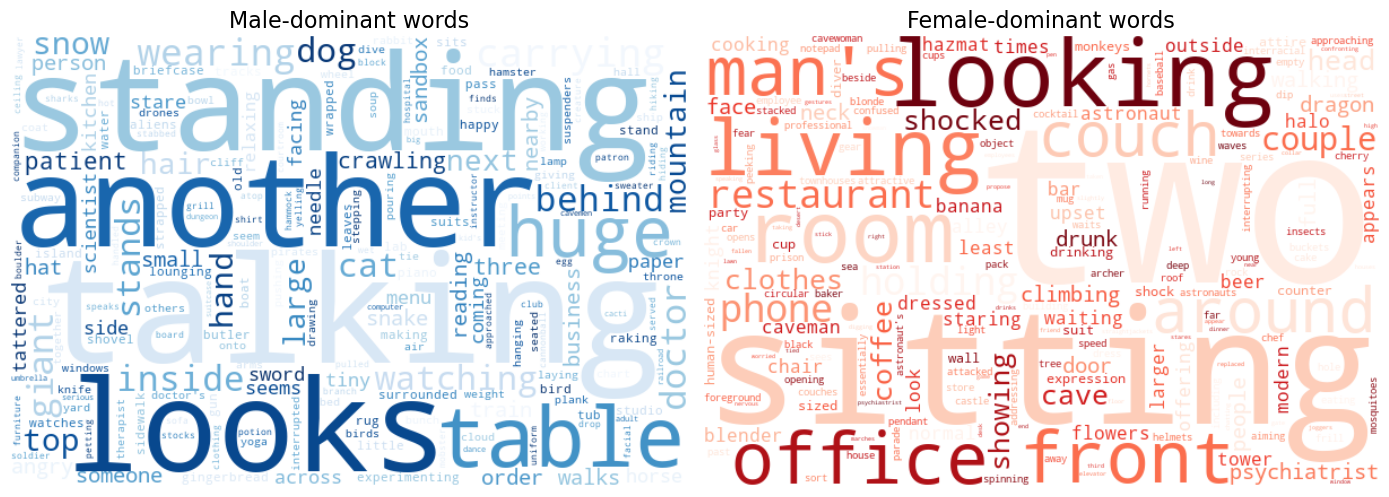

In [101]:
# --- Load the CSV data ---
df = pd.read_csv('gender.csv')

# --- Create two subsets: one for male-dominant and one for female-dominant words ---
male_words = df[df['percent_male'] > 50]
female_words = df[df['percent_male'] < 50]

# --- Build frequency dictionaries for each group ---
male_freq = dict(zip(male_words['word'], male_words['male_count']))
female_freq = dict(zip(female_words['word'], female_words['female_count']))

# --- Remove stopwords from both frequency dictionaries ---
male_freq = {word: freq for word, freq in male_freq.items() if word.lower() not in STOPWORDS}
female_freq = {word: freq for word, freq in female_freq.items() if word.lower() not in STOPWORDS}

# --- Generate the word clouds ---
male_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=200,
    stopwords=STOPWORDS
).generate_from_frequencies(male_freq)

female_cloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200,
    stopwords=STOPWORDS
).generate_from_frequencies(female_freq)

# --- Display both word clouds side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(male_cloud, interpolation='bilinear')
axes[0].set_title('Male-dominant words', fontsize=16)
axes[0].axis('off')

axes[1].imshow(female_cloud, interpolation='bilinear')
axes[1].set_title('Female-dominant words', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Interpreatation**

As an addendum, we can look at the most popular words. In this case, we will look at the 100 most frequently used words, and then compare what proportion of male subject sentences had those words and what proportion of female subject sentences had those words.

In [108]:
# --- Collect all words, excluding stopwords ---
all_words = [w for w in word_freq['none']] + \
            [w for w in word_freq['both']] + \
            [w for w in word_freq['male']] + \
            [w for w in word_freq['female']]

# --- Create dictionary with counts, filter out stopwords ---
all_words = {
    w: (word_freq['male'].get(w,0) + word_freq['female'].get(w,0) +
        word_freq['both'].get(w,0) + word_freq['none'].get(w,0))
    for w in set(all_words)
    if w.lower() not in STOPWORDS
}

# --- Print top 100 words ---
print('word\tMale\tFemale')
for word in sorted(all_words, key=all_words.get, reverse=True)[:100]:
    male_pct = 100 * word_freq['male'].get(word,0) / sentence_counter['male']
    female_pct = 100 * word_freq['female'].get(word,0) / sentence_counter['female']
    print(f'{word}\t{male_pct:.1f}%\t{female_pct:.1f}%')

word	Male	Female
man	51.2%	0.0%
two	10.5%	12.8%
woman	0.0%	60.6%
people	1.1%	3.2%
sitting	8.1%	10.6%
talking	7.3%	6.4%
looking	6.4%	8.5%
standing	5.7%	2.1%
looks	5.3%	4.3%
room	2.4%	7.4%
men	10.5%	0.0%
another	5.1%	1.1%
table	4.8%	4.3%
couple	1.1%	4.3%
look	2.0%	2.1%
giant	2.6%	2.1%
office	3.7%	5.3%
wearing	2.9%	1.1%
front	3.1%	5.3%
holding	4.4%	4.3%
walking	1.5%	3.2%
outside	0.4%	2.1%
around	2.2%	5.3%
huge	3.3%	2.1%
inside	2.4%	1.1%
watching	2.2%	1.1%
living	0.2%	6.4%
restaurant	2.4%	4.3%
behind	2.4%	1.1%
carrying	3.3%	1.1%
couch	0.7%	5.3%
face	1.8%	3.2%
three	1.5%	1.1%
staring	1.1%	2.1%
top	2.0%	0.0%
next	1.8%	1.1%
waiter	4.0%	0.0%
person	1.3%	1.1%
they're	0.0%	0.0%
head	1.3%	3.2%
house	0.7%	1.1%
dog	2.2%	0.0%
doctor	2.6%	0.0%
bunch	0.7%	0.0%
large	1.8%	1.1%
fish	0.2%	0.0%
caveman	0.9%	2.1%
king	3.3%	0.0%
cave	1.1%	3.2%
boy	3.3%	0.0%
door	0.7%	3.2%
bar	0.9%	2.1%
together	0.7%	0.0%
ground	0.4%	0.0%
island	0.9%	0.0%
knight	1.1%	2.1%
angry	1.3%	1.1%
appears	0.7%	2.1%
middle	0.9%	1.1%
co

### What's left to do:

- When is the first mention of each gender ? 

- Gender-neutral cases: Track “no gender mention/no gender in image” as a category — this helps show if humor is becoming more or less gendered over time.

- Timeline of first appearances: When did women start appearing more often? Is there a visible change after 2010 or so?

## 1. Dig a little deeper: How are men vs women depicted

## 2. Going further